In [1]:
import nltk
nltk.download('stopwords')
from google.colab import drive
import os
import pandas as pd
import tarfile
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Path file di Google Drive
tar_file_path = '/content/drive/MyDrive/Tugas NLP/ag_news_csv.tar.gz'
word2vec_path = '/content/drive/MyDrive/Tugas NLP/GoogleNews-vectors-negative300.bin.gz'
glove_path = '/content/drive/MyDrive/Tugas NLP/glove.6B.100d.txt'

In [4]:
import torch
print(torch.cuda.is_available())


False


In [5]:
!git clone https://github.com/syakiraraaa26/NLP-Tugas-Terakhir.git


Cloning into 'NLP-Tugas-Terakhir'...
fatal: could not read Username for 'https://github.com': No such device or address


**Ekstraksi Dataset**

In [6]:
# Ekstraksi dataset
extracted_path = '/content/ag_news_csv'
if not os.path.exists(extracted_path):
    with tarfile.open(tar_file_path, 'r:gz') as tar:
        tar.extractall(path=extracted_path)

In [7]:
# Periksa apakah file CSV ada
train_csv_path = os.path.join(extracted_path, 'ag_news_csv/train.csv')
test_csv_path = os.path.join(extracted_path, 'ag_news_csv/test.csv')
assert os.path.exists(train_csv_path), "File train.csv tidak ditemukan"
assert os.path.exists(test_csv_path), "File test.csv tidak ditemukan"

**Memuat Dataset**

In [8]:
# Memuat dataset
train_df = pd.read_csv(train_csv_path, header=None)
test_df = pd.read_csv(test_csv_path, header=None)

In [9]:
# Tetapkan nama kolom
train_df.columns = ['label', 'title', 'content']
test_df.columns = ['label', 'title', 'content']

# Cek beberapa baris data
print(train_df.head())
print(test_df.head())

   label                                              title  \
0      3  Wall St. Bears Claw Back Into the Black (Reuters)   
1      3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2      3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3      3  Iraq Halts Oil Exports from Main Southern Pipe...   
4      3  Oil prices soar to all-time record, posing new...   

                                             content  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  
3  Reuters - Authorities have halted oil export\f...  
4  AFP - Tearaway world oil prices, toppling reco...  
   label                                              title  \
0      3                  Fears for T N pension after talks   
1      4  The Race is On: Second Private Team Sets Launc...   
2      4      Ky. Company Wins Grant to Study Peptides (AP)   
3      4      Prediction Unit Helps For

**pre processing**

In [10]:
def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)  # Menghapus spasi berlebih
    text = re.sub(r'[^\w\s]', '', text)  # Menghapus tanda baca
    text = text.lower()  # Mengubah menjadi huruf kecil
    stop_words = set(stopwords.words('english'))
    tokens = re.split(r'\s+', text)  # Tokenisasi manual menggunakan regex
    text = ' '.join([word for word in tokens if word not in stop_words])  # Menghapus stopwords
    return text

# Terapkan preprocessing pada data
train_df['content'] = train_df['content'].apply(preprocess_text)
test_df['content'] = test_df['content'].apply(preprocess_text)

# Cek hasil setelah preprocessing
print(train_df.head())
print(test_df.head())

   label                                              title  \
0      3  Wall St. Bears Claw Back Into the Black (Reuters)   
1      3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2      3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3      3  Iraq Halts Oil Exports from Main Southern Pipe...   
4      3  Oil prices soar to all-time record, posing new...   

                                             content  
0  reuters shortsellers wall streets dwindlingban...  
1  reuters private investment firm carlyle groupw...  
2  reuters soaring crude prices plus worriesabout...  
3  reuters authorities halted oil exportflows mai...  
4  afp tearaway world oil prices toppling records...  
   label                                              title  \
0      3                  Fears for T N pension after talks   
1      4  The Race is On: Second Private Team Sets Launc...   
2      4      Ky. Company Wins Grant to Study Peptides (AP)   
3      4      Prediction Unit Helps For

**Memuat Word2Vec**

In [11]:
# Memuat model Word2Vec (Google News)
from gensim.models import KeyedVectors

In [12]:
def load_word2vec_model(path):
    return KeyedVectors.load_word2vec_format(path, binary=True)

word2vec_model = load_word2vec_model(word2vec_path)

**Memuat Glove**

In [13]:
# Memuat model GloVe
def load_glove_model(path):
    glove_model = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            glove_model[word] = vector
    return glove_model

glove_model = load_glove_model(glove_path)

**Dataset untuk Pytorch DataLoader**

In [14]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import torch

class AGNewsDataset(Dataset):
    def __init__(self, texts, labels, embedding_model=None, max_length=100):
        self.texts = texts
        self.labels = labels
        self.embedding_model = embedding_model
        self.max_length = max_length

        # Encode labels ke bentuk numerik
        self.label_encoder = LabelEncoder()
        self.encoded_labels = self.label_encoder.fit_transform(labels)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.encoded_labels[idx]

        # Tokenisasi dan konversi ke vektor
        word_vectors = [
            self.embedding_model[word] if word in self.embedding_model else np.zeros(300)
            for word in text.split()
        ]
        text_vector = np.mean(word_vectors, axis=0) if word_vectors else np.zeros(300)

        # Padding jika panjang kurang dari max_length
        if len(text_vector) < self.max_length:
            text_vector = np.pad(text_vector, (0, self.max_length - len(text_vector)))

        # Pastikan input berbentuk [batch_size, seq_len, input_dim]
        text_vector = np.expand_dims(text_vector, axis=0)  # Membuat dimensi untuk batch_size
        return torch.tensor(text_vector, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


# Dataset dan DataLoader
train_dataset = AGNewsDataset(texts=train_df['content'], labels=train_df['label'], embedding_model=word2vec_model)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


**Memuat Model**

**LSTM**

In [15]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)  # Output sesuai dengan jumlah kelas

    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        out = self.fc(hn[-1])  # Ambil output dari hidden state terakhir
        return out

# Model LSTM dengan 4 kelas
model = LSTMModel(input_dim=300, hidden_dim=256, output_dim=4)  # Menambah hidden_dim

# Perbaikan: Menggunakan AdamW dan learning rate lebih kecil
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

# Loss function
criterion = nn.CrossEntropyLoss()

# Early stopping parameters
patience = 3  # Jumlah epoch tanpa penurunan loss untuk menghentikan pelatihan
best_loss = np.inf
epochs_without_improvement = 0

def train_model(model, data_loader, num_epochs=10, learning_rate=0.0001):
    global best_loss, epochs_without_improvement
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Model Training Loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)  # Output model: [batch_size, num_classes]
            loss = criterion(outputs, labels)  # Loss: output [batch_size, num_classes], labels [batch_size]
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(data_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

        # Early stopping check
        if avg_loss < best_loss:
            best_loss = avg_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1} due to no improvement in loss.")
            break

# Mulai pelatihan
train_model(model, train_loader, num_epochs=10, learning_rate=0.0001)


Epoch 1/10, Loss: 0.5406
Epoch 2/10, Loss: 0.3752
Epoch 3/10, Loss: 0.3601
Epoch 4/10, Loss: 0.3520
Epoch 5/10, Loss: 0.3466
Epoch 6/10, Loss: 0.3424
Epoch 7/10, Loss: 0.3387
Epoch 8/10, Loss: 0.3354
Epoch 9/10, Loss: 0.3327
Epoch 10/10, Loss: 0.3303


**Fast Text**

In [16]:
#train model
def train_model(model, data_loader, num_epochs=10, learning_rate=0.0001):
    global best_loss, epochs_without_improvement
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Model Training Loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)  # Output model: [batch_size, num_classes]

            # Loss function expects labels to be integers (not one-hot)
            loss = criterion(outputs, labels)  # Labels in the form of [batch_size] for classification
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(data_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

        # Early stopping check
        if avg_loss < best_loss:
            best_loss = avg_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1} due to no improvement in loss.")
            break


In [17]:
class FastTextModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FastTextModel, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        return self.fc(x)

# Model FastText dengan 4 kelas
fasttext_model = FastTextModel(input_dim=300, output_dim=4)  # Menggunakan dimensi embedding 300 dari Word2Vec

# Perbaikan: Menggunakan AdamW dan learning rate lebih kecil
optimizer = optim.AdamW(fasttext_model.parameters(), lr=0.0001)

# Pelatihan model FastText
train_model(fasttext_model, train_loader, num_epochs=10, learning_rate=0.0001)

Epoch 1/10, Loss: 1.0495
Epoch 2/10, Loss: 0.6881
Epoch 3/10, Loss: 0.5508
Early stopping at epoch 3 due to no improvement in loss.


**Transformer**

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, vocab_size):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, input_dim)  # Menggunakan nn.Embedding
        self.transformer = nn.Transformer(input_dim, nhead=8, num_encoder_layers=6)
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # Pastikan input x berbentuk (batch_size, seq_len)
        print(f"Dimensi input sebelum embedding: {x.shape}")

        x = self.embedding(x)  # Hasilnya akan berbentuk (batch_size, seq_len, input_dim)

        # Cek dimensi input setelah embedding
        print(f"Dimensi setelah embedding: {x.shape}")

        # Pastikan input ke transformer berbentuk [seq_len, batch_size, input_dim]
        x = x.permute(1, 0, 2)  # Ubah urutan menjadi (seq_len, batch_size, input_dim)

        # Proses Transformer
        x = self.transformer(x, x)  # Transformer membutuhkan input dengan bentuk (seq_len, batch_size, input_dim)

        # Ambil output dari token terakhir
        out = self.fc(x[-1, :, :])  # Ambil output dari token terakhir (seq_len, batch_size, input_dim)
        return out

# Tentukan vocab_size dan dimensi input
vocab_size = 10000  # Misalnya, Anda dapat mengganti dengan ukuran vocab Anda
input_dim = 256  # Sesuaikan dengan dimensi embedding yang Anda inginkan
output_dim = 4  # Jumlah kelas

# Model Transformer
transformer_model = TransformerModel(input_dim=input_dim, output_dim=output_dim, vocab_size=vocab_size)

# Optimizer dan Loss Function
optimizer = optim.AdamW(transformer_model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# Membuat dataset dummy untuk pelatihan (untuk contoh)
inputs_tensor = torch.randint(0, vocab_size, (1000, 32))  # 1000 sampel, 32 kata dalam setiap kalimat
labels_tensor = torch.randint(0, output_dim, (1000,))  # 1000 label (misalnya 4 kelas)

# Membuat dataset dan data loader
dataset = TensorDataset(inputs_tensor, labels_tensor)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Fungsi untuk melatih model dengan Early Stopping
def train_model_with_early_stopping(model, data_loader, num_epochs=10, learning_rate=0.0001, patience=3):
    model.train()
    best_loss = float('inf')  # Set loss terbaik sangat tinggi di awal
    epochs_without_improvement = 0  # Hitung epoch tanpa perbaikan

    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, labels in data_loader:
            # Pastikan input memiliki bentuk yang benar [batch_size, seq_len]
            inputs = inputs.long()  # Ubah ke LongTensor untuk digunakan dalam embedding

            # Cek dimensi input sebelum proses model
            print(f"Dimensi input sebelum proses model: {inputs.shape}")

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(data_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

        # Early Stopping check
        if avg_loss < best_loss:
            best_loss = avg_loss
            epochs_without_improvement = 0  # Reset jika ada perbaikan
        else:
            epochs_without_improvement += 1

        # Jika tidak ada perbaikan dalam 'patience' epoch, berhenti
        if epochs_without_improvement >= patience:
            print(f"Early stopping pada epoch {epoch+1} karena tidak ada perbaikan dalam loss.")
            break

# Coba pelatihan dengan early stopping
train_model_with_early_stopping(transformer_model, data_loader, num_epochs=10, learning_rate=0.0001, patience=3)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Dimensi input sebelum proses model: torch.Size([32, 32])
Dimensi input sebelum embedding: torch.Size([32, 32])
Dimensi setelah embedding: torch.Size([32, 32, 256])
Dimensi input sebelum proses model: torch.Size([32, 32])
Dimensi input sebelum embedding: torch.Size([32, 32])
Dimensi setelah embedding: torch.Size([32, 32, 256])
Dimensi input sebelum proses model: torch.Size([32, 32])
Dimensi input sebelum embedding: torch.Size([32, 32])
Dimensi setelah embedding: torch.Size([32, 32, 256])
Dimensi input sebelum proses model: torch.Size([32, 32])
Dimensi input sebelum embedding: torch.Size([32, 32])
Dimensi setelah embedding: torch.Size([32, 32, 256])
Dimensi input sebelum proses model: torch.Size([32, 32])
Dimensi input sebelum embedding: torch.Size([32, 32])
Dimensi setelah embedding: torch.Size([32, 32, 256])
Dimensi input sebelum proses model: torch.Size([32, 32])
Dimensi input sebelum embedding: torch.Size([32, 32])
Dimensi setelah embedding: torch.Size([32, 32, 256])
Dimensi input se

**BERT**

In [19]:
# Install library jika belum terinstal
!pip install transformers torch -q

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
import time
import copy

# Cek perangkat (CPU saja)
device = torch.device("cpu")
print(f"Device: {device}")

# Load Model dan Tokenizer BERT Tiny
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")
model = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=3).to(device)

# Perbaikan label dataset
# Ubah label di luar range [0, 1, 2] menjadi 2
train_df['label'] = train_df['label'].apply(lambda x: 2 if x > 2 else x)
test_df['label'] = test_df['label'].apply(lambda x: 2 if x > 2 else x)

print("Label unik di train_df:", train_df['label'].unique())
print("Label unik di test_df:", test_df['label'].unique())

# Dataset Class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=64):
        self.encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=max_length, return_tensors='pt')
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings['input_ids'][idx],
            "attention_mask": self.encodings['attention_mask'][idx],
            "labels": self.labels[idx],
        }

# Membuat DataLoader
train_dataset = TextDataset(train_df['content'].tolist(), train_df['label'].tolist(), tokenizer)
test_dataset = TextDataset(test_df['content'].tolist(), test_df['label'].tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # Batch size kecil untuk CPU
test_loader = DataLoader(test_dataset, batch_size=8)

# Konfigurasi Early Stopping
class EarlyStopping:
    def __init__(self, patience=2, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def step(self, loss):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

# Training Loop dengan Checkpoint
def train_model(model, train_loader, test_loader, optimizer, scheduler, num_epochs=10, gradient_accumulation_steps=2):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    early_stopping = EarlyStopping(patience=3)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Training Phase
        model.train()
        running_loss = 0.0
        optimizer.zero_grad()

        for step, batch in enumerate(train_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss / gradient_accumulation_steps  # Gradient Accumulation
            loss.backward()

            if (step + 1) % gradient_accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            running_loss += loss.item() * gradient_accumulation_steps

        epoch_loss = running_loss / len(train_loader)
        print(f"Training Loss: {epoch_loss:.4f}")

        # Validation Phase
        model.eval()
        val_loss = 0.0
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            with torch.no_grad():
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()

        val_loss /= len(test_loader)
        print(f"Validation Loss: {val_loss:.4f}")

        # Early Stopping Check
        if early_stopping.step(val_loss):
            print("Early stopping triggered!")
            break

        # Save Best Model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), "best_model_checkpoint_cpu.pth")
            print("Model checkpoint saved!")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Optimizer, Scheduler, dan Hyperparameter
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 10)

# Training
start_time = time.time()
trained_model = train_model(model, train_loader, test_loader, optimizer, scheduler, num_epochs=10)
end_time = time.time()

print(f"Training complete in {(end_time - start_time)/60:.2f} minutes.")


Device: cpu


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Label unik di train_df: [2 1]
Label unik di test_df: [2 1]


model.safetensors:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Epoch 1/10
Training Loss: 0.1697
Validation Loss: 0.1288
Model checkpoint saved!
Epoch 2/10
Training Loss: 0.1073
Validation Loss: 0.1202
Model checkpoint saved!
Epoch 3/10
Training Loss: 0.0827
Validation Loss: 0.1129
Model checkpoint saved!
Epoch 4/10
Training Loss: 0.0649
Validation Loss: 0.1183
Epoch 5/10
Training Loss: 0.0507
Validation Loss: 0.1274
Epoch 6/10
Training Loss: 0.0401
Validation Loss: 0.1384
Early stopping triggered!
Training complete in 110.98 minutes.


**Evaluasi Model**

In [37]:
# Evaluasi LSTM
def evaluate_lstm(model, data_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in data_loader:
            # Ambil input_ids dan labels dari batch
            inputs = batch['input_ids'].to(device).long()  # Menggunakan 'input_ids' untuk input
            labels = batch['labels'].to(device)  # Menggunakan 'labels' untuk target

            # Proses model
            outputs = model(inputs)
            logits = outputs.logits  # Ambil logits dari output model
            _, preds = torch.max(logits, 1)  # Ambil prediksi dari logits
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Hitung akurasi dan laporan klasifikasi
    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds)
    return acc, report

# Evaluasi LSTM
print("Evaluasi LSTM:")
lstm_acc, lstm_report = evaluate_lstm(lstm_model, test_loader, device)  # Menggunakan test_loader untuk evaluasi
print(f"Accuracy: {lstm_acc:.4f}")
print(lstm_report)


Evaluasi LSTM:
Accuracy: 0.9517
              precision    recall  f1-score   support

           1       0.97      0.83      0.90      1900
           2       0.95      0.99      0.97      5700

    accuracy                           0.95      7600
   macro avg       0.96      0.91      0.93      7600
weighted avg       0.95      0.95      0.95      7600



In [44]:
# Evaluasi FastText
def evaluate_fasttext(model, data_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in data_loader:
            # Jika batch berupa dictionary, akses input_ids dan labels
            if isinstance(batch, dict):
                inputs = batch['input_ids'].to(device).long()  # Ambil 'input_ids' dari batch
                labels = batch['labels'].to(device)  # Ambil 'labels' dari batch
            else:
                # Jika batch berupa tuple (inputs, labels)
                inputs, labels = batch
                inputs, labels = inputs.to(device).long(), labels.to(device)

            # Cek dimensi input dan pastikan sesuai dengan model
            print(f"Input size: {inputs.size()}")  # Cek ukuran input

            # Pastikan input sesuai dengan dimensi yang diinginkan
            # Misalnya, model mengharapkan dimensi 300
            if inputs.size(1) != 300:
                # Lakukan padding atau crop untuk memotong input menjadi dimensi yang diinginkan
                if inputs.size(1) > 300:
                    inputs = inputs[:, :300]  # Memotong input jika terlalu panjang
                else:
                    padding = 300 - inputs.size(1)
                    inputs = torch.cat([inputs, torch.zeros(inputs.size(0), padding).to(device)], dim=1)

            # Pastikan input dalam tipe float
            inputs = inputs.float()  # Ubah ke float untuk model

            # Proses model
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds)
    return acc, report

# Evaluasi FastText
print("Evaluasi FastText:")
fasttext_acc, fasttext_report = evaluate_fasttext(fasttext_model, train_loader, device)
print(f"Accuracy: {fasttext_acc:.4f}")
print(fasttext_report)


Streaming output truncated to the last 5000 lines.
Input size: torch.Size([8, 64])
Input size: torch.Size([8, 64])
Input size: torch.Size([8, 64])
Input size: torch.Size([8, 64])
Input size: torch.Size([8, 64])
Input size: torch.Size([8, 64])
Input size: torch.Size([8, 64])
Input size: torch.Size([8, 64])
Input size: torch.Size([8, 64])
Input size: torch.Size([8, 64])
Input size: torch.Size([8, 64])
Input size: torch.Size([8, 64])
Input size: torch.Size([8, 64])
Input size: torch.Size([8, 64])
Input size: torch.Size([8, 64])
Input size: torch.Size([8, 64])
Input size: torch.Size([8, 64])
Input size: torch.Size([8, 64])
Input size: torch.Size([8, 64])
Input size: torch.Size([8, 64])
Input size: torch.Size([8, 64])
Input size: torch.Size([8, 64])
Input size: torch.Size([8, 64])
Input size: torch.Size([8, 64])
Input size: torch.Size([8, 64])
Input size: torch.Size([8, 64])
Input size: torch.Size([8, 64])
Input size: torch.Size([8, 64])
Input size: torch.Size([8, 64])
Input size: torch.Siz

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [50]:
# Evaluasi Transformer
def evaluate_transformer(model, data_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in data_loader:
            # Memisahkan inputs dan labels
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)  # Pindahkan ke device

            # Cek dimensi input sebelum diproses model
            print(f"Dimensi input sebelum proses model: {inputs.shape}")

            # Jalankan model
            outputs = model(inputs)

            # Ambil prediksi dan evaluasi
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Hitung akurasi dan laporan klasifikasi
    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds)
    return acc, report

# Evaluasi Transformer
print("Evaluasi Transformer:")
transformer_acc, transformer_report = evaluate_transformer(transformer_model, data_loader, device)
print(f"Accuracy: {transformer_acc:.4f}")
print(transformer_report)


Evaluasi Transformer:
Dimensi input sebelum proses model: torch.Size([32, 32])
Dimensi input sebelum embedding: torch.Size([32, 32])
Dimensi setelah embedding: torch.Size([32, 32, 256])
Dimensi input sebelum proses model: torch.Size([32, 32])
Dimensi input sebelum embedding: torch.Size([32, 32])
Dimensi setelah embedding: torch.Size([32, 32, 256])
Dimensi input sebelum proses model: torch.Size([32, 32])
Dimensi input sebelum embedding: torch.Size([32, 32])
Dimensi setelah embedding: torch.Size([32, 32, 256])
Dimensi input sebelum proses model: torch.Size([32, 32])
Dimensi input sebelum embedding: torch.Size([32, 32])
Dimensi setelah embedding: torch.Size([32, 32, 256])
Dimensi input sebelum proses model: torch.Size([32, 32])
Dimensi input sebelum embedding: torch.Size([32, 32])
Dimensi setelah embedding: torch.Size([32, 32, 256])
Dimensi input sebelum proses model: torch.Size([32, 32])
Dimensi input sebelum embedding: torch.Size([32, 32])
Dimensi setelah embedding: torch.Size([32, 32, 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [51]:
# Evaluasi BERT
def evaluate_bert(model, data_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            _, preds = torch.max(logits, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds)
    return acc, report

# Evaluasi BERT
print("Evaluasi BERT:")
bert_acc, bert_report = evaluate_bert(trained_model, test_loader, device)
print(f"Accuracy: {bert_acc:.4f}")
print(bert_report)


Evaluasi BERT:
Accuracy: 0.9645
              precision    recall  f1-score   support

           1       0.94      0.91      0.93      1900
           2       0.97      0.98      0.98      5700

    accuracy                           0.96      7600
   macro avg       0.96      0.95      0.95      7600
weighted avg       0.96      0.96      0.96      7600



In [52]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience


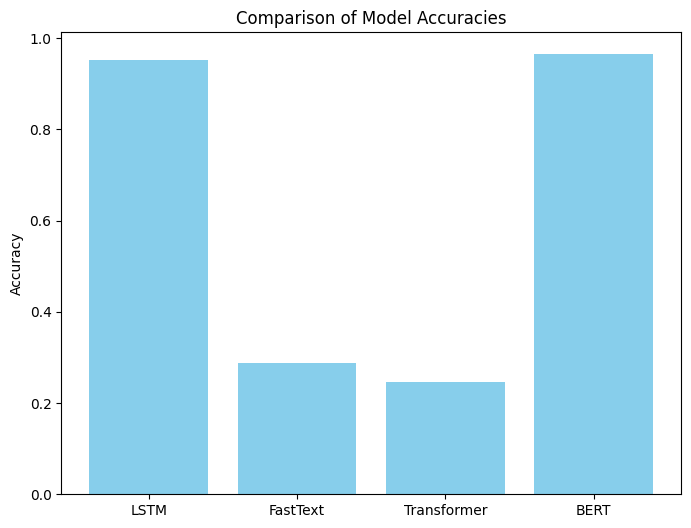

In [53]:
import matplotlib.pyplot as plt

# Contoh visualisasi hasil akurasi
models = ['LSTM', 'FastText', 'Transformer', 'BERT']
accuracies = [lstm_acc, fasttext_acc, transformer_acc, bert_acc]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color='skyblue')
plt.title('Comparison of Model Accuracies')
plt.ylabel('Accuracy')
plt.show()


percobaan

In [ ]:
# Import Libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score

# Cek device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Normalisasi label agar sesuai dengan [0, 3]
train_df['label'] = train_df['label'] - 1
test_df['label'] = test_df['label'] - 1

# Tokenizer DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Dataset class
class AGNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoded = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )
        return (
            encoded["input_ids"].squeeze(0),
            encoded["attention_mask"].squeeze(0),
            torch.tensor(label, dtype=torch.long),
        )

# Buat dataset dan dataloader
train_dataset = AGNewsDataset(train_df["content"], train_df["label"], tokenizer)
test_dataset = AGNewsDataset(test_df["content"], test_df["label"], tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Model DistilBERT
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=4)
model = model.to(device)

# Optimizer dan Loss Function
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

# Early stopping
class EarlyStopping:
    def __init__(self, patience=3):
        self.patience = patience
        self.best_loss = float("inf")
        self.counter = 0

    def step(self, loss):
        if loss < self.best_loss:
            self.best_loss = loss
            self.counter = 0
            return False  # Belum berhenti
        else:
            self.counter += 1
            return self.counter >= self.patience  # Berhenti jika counter mencapai batas

# Fungsi pelatihan
def train_model(model, train_loader, num_epochs=10, patience=3):
    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for inputs, attention_mask, labels in train_loader:
            inputs, attention_mask, labels = (
                inputs.to(device),
                attention_mask.to(device),
                labels.to(device),
            )

            optimizer.zero_grad()
            outputs = model(input_ids=inputs, attention_mask=attention_mask).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

        # Cek Early Stopping
        if early_stopping.step(avg_loss):
            print(f"Early stopping at epoch {epoch+1}")
            break

# Fungsi evaluasi
def evaluate_model(model, test_loader):
    model.eval()
    total_correct = 0
    total_samples = 0

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, attention_mask, labels in test_loader:
            inputs, attention_mask, labels = (
                inputs.to(device),
                attention_mask.to(device),
                labels.to(device),
            )

            outputs = model(input_ids=inputs, attention_mask=attention_mask).logits
            predictions = torch.argmax(outputs, dim=1)
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    print(f"Accuracy: {accuracy:.4f}")

# Latih model
train_model(model, train_loader, num_epochs=10, patience=3)

# Evaluasi model
evaluate_model(model, test_loader)
